# Legal Document Classifier
by Adetunji, Philip

### Objective
Build a Natural Language Processing (NLP) pipeline that classifies legal case reports into specific areas of law, using the dataset provided.

### Dataset Overview

The dataset contains the following columns:

- case_title – Title of the legal case
- suitno – Suit number or case reference
- introduction – Brief introduction (includes area of law)
- facts – Summary of the facts of the case
- issues – Legal issues considered in the case
- decision – The decision or judgment
- full_report – The full body of the legal judgment

Example label values (from introduction):
- Criminal Law and Procedure
- Civil Procedure
- Enforcement of Fundamental Rights
- Company Law, etc.

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import nltk
from nltk.corpus import stopwords
import html
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [ ]:
# load data
data = pd.read_csv("data/sample_200_rows.csv")

# view first few rows
data.head()

,case_title,suitno,introduction,facts,issues,decision,full_report
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.\n,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri..."
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ..."
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le..."
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO&nbsp;OHO, J.C.A. (Deliveri..."


In [ ]:
# check no. of rows and columns
data.shape

(200, 7)

There are 200 case reports.

In [ ]:
# check for duplicates
data.duplicated().sum()

np.int64(0)

In [ ]:
# check for missing values
data.isnull().sum()

,0
case_title,0
suitno,0
introduction,0
facts,0
issues,1
decision,0
full_report,0


In [ ]:
# view row with missing value
missing = data[data.issues.isnull()]
missing

,case_title,suitno,introduction,facts,issues,decision,full_report
183,BELLVIEW AIRLINES LIMITED v. ALUMINIUM CITY LI...,CA/L/436/05,This appeal borders on Arbitration and Concili...,This is an appeal against the decision of the...,NaN,"In the final analysis, the Court of Appeal dis...","ISA AYO SALAMI, J.C.A.: (Delivering the Leadin..."


Since there is only one single instance of missing values, which is also less than 5% of the total dataset, it is safe to drop the row with the issing value.

In [ ]:
# drop row with missing value
data = data.drop(missing.index, axis = 'index')
# confirm that it was removed
print(data.shape)
data.isnull().sum()

(199, 7)


,0
case_title,0
suitno,0
introduction,0
facts,0
issues,0
decision,0
full_report,0


### Data Preprocessing
Case_title, suitno and decision columns are not useful in building the classifier, so they will be dropped.

In [ ]:
# extract relevant columns and create a copy
df = data[["introduction", "full_report", "facts", "issues"]].copy()
df.head()

,introduction,full_report,facts,issues
0,This appeal borders on Civil Procedure.\n,"GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri...",The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...
1,This is a ruling on an Application seeking Lea...,\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...
2,This appeal borders on propriety of requiremen...,"PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ...",This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...
3,This appeal borders on Criminal Law and Proced...,"IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le...",This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...
4,This appeal borders on Enforcement of Fundamen...,"FREDERICK OZIAKPONO&nbsp;OHO, J.C.A. (Deliveri...",This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...


### Extract label from introduction column

In [ ]:
# get a clearer view of the introduction column
li = []
li.append([t for t in df.introduction[0:10]])
li

[['This appeal borders on Civil Procedure.\n',
  'This is a ruling on an Application seeking Leave of Court to substitute parties; Leave to Join Parties and Extension of time within which to file Notice and Grounds of Appeal.\n',
  'This appeal borders on propriety of requirement of consent of the A.G. of the Federation in a garnishee proceedings against the CBN.',
  'This appeal borders on Criminal Law and Procedure.\n',
  'This appeal borders on Enforcement of Fundamental Right to Liberty.\n',
  'This appeal borders on Civil Procedure.\n',
  'This appeal borders on the jurisdiction of the Sharia Court of Appeal.\n',
  'This appeal borders on the Offences of Conspiracy to Murder and Attempt to Murder.\n',
  'This appeal borders on Election Petition.',
  'This appeal borders on civil procedure.']]

In [ ]:
def extract_after_last_on(text):
    # Find all matches of 'on' as whole word (case-insensitive)
    matches1 = list(re.finditer(r'\bon\b', text, flags=re.IGNORECASE))
    matches2 = list(re.finditer(r'\bseeking\b', text, flags=re.IGNORECASE))
    if not matches1 or matches2:
        return None  # or "" if you prefer
    # Get the position of the last 'on'
    if matches1:
      last_on_pos = matches1[-1].end()
    if matches2:
      last_on_pos = matches2[-1].end()
    # Extract substring after the last 'on'
    after_text = text[last_on_pos:].strip().lower()
    return after_text

# Apply to your DataFrame column
df['after_last_on'] = df['introduction'].apply(extract_after_last_on)
df['after_last_on'] = df['after_last_on'].apply(lambda x: x.lower() if isinstance(x, str) else x)
df['after_last_on'] = df['after_last_on'].apply(lambda x: x.replace(".","") if isinstance(x, str) else x)

# View results
print(df[['introduction', 'after_last_on']].head())


                                        introduction  \
0          This appeal borders on Civil Procedure.\n   
1  This is a ruling on an Application seeking Lea...   
2  This appeal borders on propriety of requiremen...   
3  This appeal borders on Criminal Law and Proced...   
4  This appeal borders on Enforcement of Fundamen...   

                                       after_last_on  
0                                    civil procedure  
1                                               None  
2  propriety of requirement of consent of the ag ...  
3                         criminal law and procedure  
4        enforcement of fundamental right to liberty  


In [ ]:
print(df.after_last_on.value_counts())
# get area laws that aoccur more frequently
area_laws = df.after_last_on.value_counts().index[:4]
area_laws = area_laws.tolist()
area_laws

after_last_on
civil procedure                        43
election petition                      17
land law                               15
criminal law and procedure             10
the offence of murder                   4
                                       ..
chieftaincy matters                     1
the offence of culpable homicide        1
recovery of premises                    1
doctrine of laches and acquiescence     1
a motion for stay of proceedings        1
Name: count, Length: 89, dtype: int64


['civil procedure',
 'election petition',
 'land law',
 'criminal law and procedure']

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

area_laws.extend(['Enforcement of Fundamental right','Other'])
# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight and fast

# Compute embeddings for area laws/topics
topic_embeddings = model.encode(area_laws, convert_to_tensor=True)

# Compute embeddings for your DataFrame introductions
intro_embeddings = model.encode(df['after_last_on'].tolist(), convert_to_tensor=True)

# Compute cosine similarity between each intro and each topic
cosine_scores = util.cos_sim(intro_embeddings, topic_embeddings)  # shape: (num_rows, num_topics)

# For each row, find the index of the topic with the highest similarity
import torch

top_scores, top_indices = torch.max(cosine_scores, dim=1)

# Map indices to topic names and scores
df['label'] = [area_laws[idx] for idx in top_indices.cpu().numpy()]
df['similarity_score'] = top_scores.cpu().numpy()


In [ ]:

# View results
print(df[['introduction', 'label', 'similarity_score']].head())


                                        introduction  \
0          This appeal borders on Civil Procedure.\n   
1  This is a ruling on an Application seeking Lea...   
2  This appeal borders on propriety of requiremen...   
3  This appeal borders on Criminal Law and Proced...   
4  This appeal borders on Enforcement of Fundamen...   

                              label  similarity_score  
0                   civil procedure          1.000000  
1                             Other          0.432763  
2                   civil procedure          0.372604  
3        criminal law and procedure          1.000000  
4  Enforcement of Fundamental right          0.799616  


In [ ]:
df.label.value_counts()

,count
label,
civil procedure,66
criminal law and procedure,47
land law,42
election petition,26
Enforcement of Fundamental right,13
Other,5


### Clean Full_report column - feature

In [ ]:
# get a clearer view of the full_report column
data.full_report[0]

'GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Delivering the Leading Judgment): The appellant as Plaintiff before the Lagos High Court issued a specially indorsed writ of summons pursuant to Order 3 Rules 4 and 9 of the Lagos State Civil Procedure Rules claiming from the 1st and 2nd Respondents (as 1st and 2nd Defendants) the sum of N500,000 being credit facilities granted by the Plaintiff to the 1st Defendant. Interest and penalty were also claimed on the principal sum. In compliance with the rules, a Statement of Claim was filed along with the writ of summons.\n\nThe Plaintiff thereafter brought a motion ex-parte praying for an order:\n"Removing into the custody of this Honourable Court, the Peugeot 503 Saloon Car with Registration No. LA 1000R; the Volkswagen Jetta Saloon Car with Registration No. LA 556R and the Volkswagen Jetta Saloon Car with Registration No. LA 557R property of the 1st defendant pending the determination of the motion on Notice"\n\nIn paragraphs 2(i), 4, 5, 6, 7, and 8

In [ ]:
# function to clean and standardise the feature column
def clean(df,column):

  # remove non-breaking space
  df[column] = df[column].apply(lambda x: ' '.join(html.unescape(word).replace("\xa0", " ") for word in x.split()))

  # save the pattern for the punctuation and special characters in regex
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))

  # replace the punctuation with nothing for each word in the list
  # and join the words back into a string
  df[column] = df[column].apply(lambda x: ' '.join([re_punc.sub('', word) for word in x.split()]))

  # remove extra special characters not handled above
  df[column] = df[column].apply(lambda x: ' '.join([re.sub(r'[’,-, @]','', word) for word in x.split()]))

  # remove non-alphabets
  df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

  # filter out stop words
  stop_words = set(stopwords.words('english'))
  df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if not word in stop_words]))

  #remove extra whitspace
  df[column] = df[column].apply(lambda x: x.strip())

  # lower case
  df[column] = df[column].apply(lambda x: x.lower())


  print("Data successfully cleaned!")


  return df[column]

In [ ]:
df = df.drop('after_last_on', axis='columns')
df = df.drop('similarity_score', axis='columns')

In [ ]:
# clean the entire column
for i in df.columns:
  df[i] = clean(df,i)
#df.full_report = clean(df, 'full_report')
# view cleaned column
df.head()


Data successfully cleaned!
Data successfully cleaned!
Data successfully cleaned!
Data successfully cleaned!
Data successfully cleaned!


,introduction,full_report,facts,issues,label
0,this appeal borders civil procedure,george adesola oguntade jca delivering leading...,the appellant plaintiff lagos high court issue...,the appellant formulated following issues thus...,civil procedure
1,this ruling application seeking leave court su...,chioma egondu nwosuiheme jca delivering lead r...,the present application flows judgment high co...,the court determined proprietary otherwise app...,other
2,this appeal borders propriety requirement cons...,peter oyinkenimiemi affen jca delivering leadi...,this appeal emanated decision federal high cou...,the court appeal determined appeal based sole ...,civil procedure
3,this appeal borders criminal law procedure,ibrahim shata bdliya jca deliveringthe leading...,this appeal judgment federal high court jos de...,the court determined appeal following issues w...,criminal law procedure
4,this appeal borders enforcement fundamental ri...,frederick oziakpono oho jca delivering leading...,this appeal judgment ngozi opara j high court ...,appellant formulated issues respondent raised ...,enforcement fundamental right


### Tokenization and Vectorization

In [ ]:
# Combine the cleaned text from the relevant columns into a single string per row
text_cols = [i for i in df.columns]

# Create a new column with the combined text
df['combined_text'] = df[text_cols].agg(' '.join, axis=1)

def vectorize(text):
    # Generating Embeddings using tokenizer
    tokenizer = Tokenizer(num_words=500, split=' ')
    # Fit tokenizer on the combined text from all rows
    tokenizer.fit_on_texts(text)

    # Convert the combined text into sequences
    X = tokenizer.texts_to_sequences(text)

    # Pad the sequences
    X = pad_sequences(X)
    return X, tokenizer
X, tokenizer = vectorize(df['combined_text'].values)

In [ ]:
X

array([[  0,   0,   0, ...,  24, 160, 150],
       [  0,   0,   0, ...,   1, 295,  47],
       [  0,   0,   0, ..., 122, 160, 150],
       ...,
       [  0,   0,   0, ..., 415, 173,  35],
       [  0,   0,   0, ..., 391, 160, 150],
       [  0,   0,   0, ...,   9,  59,  79]], dtype=int32)

In [ ]:
# Encode labels
df['label'] = df['label'].apply(lambda x: x.strip())
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])


In [ ]:
df['label'].value_counts()

,count
label,
0,66
1,47
4,42
2,26
3,13
5,5


That is:

civil procedure	- 0
criminal law and procedure	- 1
land law	- 4
election petition	- 2
Enforcement of Fundamental right	- 3
Other - 5

### Modelling

In [ ]:
# Build model and calculate the accuracy
def build(model):
    model = model().fit(X_train, y_train)

    return model
def result(model):
    # predicting and calculating accuracy
    predict = model.predict(X_test)
    # classification report
    print(classification_report(y_test,predict))
    # plot confusion matrix
    cm = confusion_matrix(y_test,predict)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        10
           3       0.60      1.00      0.75         3
           4       1.00      1.00      1.00        14
           5       0.00      0.00      0.00         2

    accuracy                           0.97        60
   macro avg       0.77      0.83      0.79        60
weighted avg       0.95      0.97      0.95        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


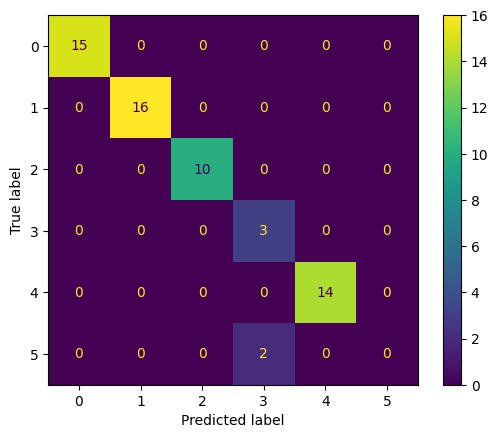

In [ ]:
# define target and features
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

model = build(DecisionTreeClassifier)
result(model)

In [ ]:
# Define the model
model = DecisionTreeClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation accuracy: 0.9785714285714286


In [ ]:
# The best model after tuning is stored here:
best_model = grid_search.best_estimator_

# You can now use best_model to predict or evaluate
y_pred = best_model.predict(X_test)

In [ ]:
#saving the best model

joblib.dump(best_model, 'DT_model.pkl')

['DT_model.pkl']

In [ ]:
#saving the vectorizer

joblib.dump(tokenizer, 'vect.pkl')

['vect.pkl']